# Charts, Layouts & Deployment

::::: {.grid}

:::: {.g-col-6}

::: {.callout-note appearance="minimal"}
## Lecture learning goals

1. Create charts in dashboards
2. Update charts via callbacks
3. Use bootstrap components to lay out components on grid
4. Implement cards and tabs for appropriate purposes
5. Keep the code tidy by defining components outside the layout
6. Deploy your app publically
7. Set up pull request deploy previews


:::
    
::::

:::: {.g-col-6}

::: {.callout-note appearance="minimal"}
## Required activities

- There are several optional readings linked throughout these notes where you can learn more about Dash and Shiny.

*You can read these either before or after class*               

:::

::::

:::::

**Lecture slides**

No slides this week.

## Charts

### Dash

Dash has support for several plotting libraries,
most notably Plotly, Altair, and Holoviz
(but you can also use e.g. matplotlib/seaborn
 if interactivity is not important to you).
To display a plotly charts you use the `dcc.Graph` component,
and to display an altair chart you use the `dvc.Vega` component
from the `dash_vega_components` library:

```python
import altair as alt
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
from dash import Dash
from vega_datasets import data


# Initiatlize the app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

cars = data.cars()
chart = alt.Chart(cars).mark_point().encode(
    x='Horsepower',
    y='Miles_per_Gallon',
    tooltip='Origin'
).interactive()

# Layout
app.layout = dbc.Container([
    # Note that you need to pass the chart as a dictionary via `to_dict()`
    dvc.Vega(spec=chart.to_dict()),
])

# Server side callbacks/reactivity
# ...

# Run the app/dashboard
if __name__ == '__main__':
    app.run(debug=True)
```

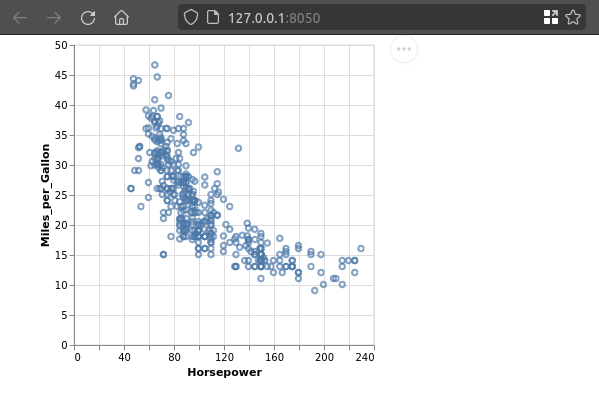

We could also add a checkbox to show/hide the chart.
Note how we are setting the `spec` property of the `dvc.Vega` component
to an empty dictionary
and then only returning the chart if the checkbox is checked.

```python
# Layout
app.layout = dbc.Container([
    dcc.Checklist(id='show_chart', options=[' Show chart']),
    dvc.Vega(id='scatter', spec={})
])

# Server side callbacks/reactivity
@callback(
    Output('scatter', 'spec'),
    Input('show_chart', 'value')
)
def create_chart(show_chart):
    if show_chart:
        return chart.to_dict()
    else:
        return {}
```

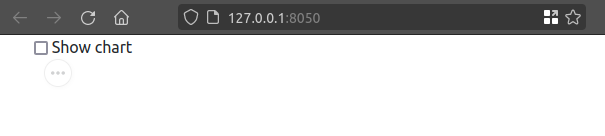

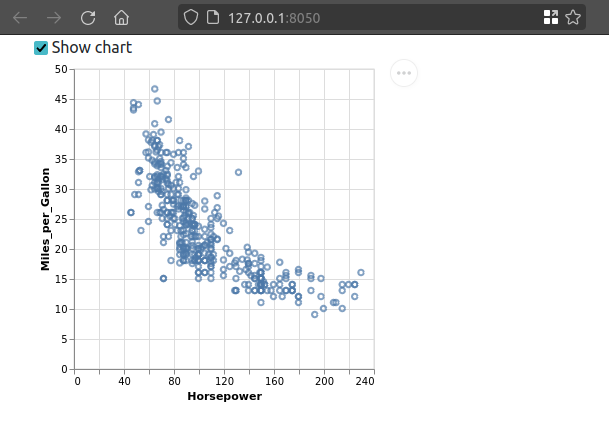

A more interesting example would be to use a dropdown
to select what is shown in the chart.
We can do this to either control which column is shown on the axes,
or filter the data.
Let's see the former first.

```python
from dash import Dash, dcc, callback, Output, Input
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
import altair as alt
from vega_datasets import data


cars = data.cars()

# Initiatlize the app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout
app.layout = dbc.Container([
    dvc.Vega(id='scatter', spec={}),
    dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'),
])

# Server side callbacks/reactivity
@callback(
    Output('scatter', 'spec'),
    Input('x-col', 'value')
)
def create_chart(x_col):
    return(
        alt.Chart(cars).mark_point().encode(
            x=x_col,
            y='Miles_per_Gallon',
            tooltip='Origin'
        ).interactive().to_dict()
    )

# Run the app/dashboard
if __name__ == '__main__':
    app.run(debug=True)
```

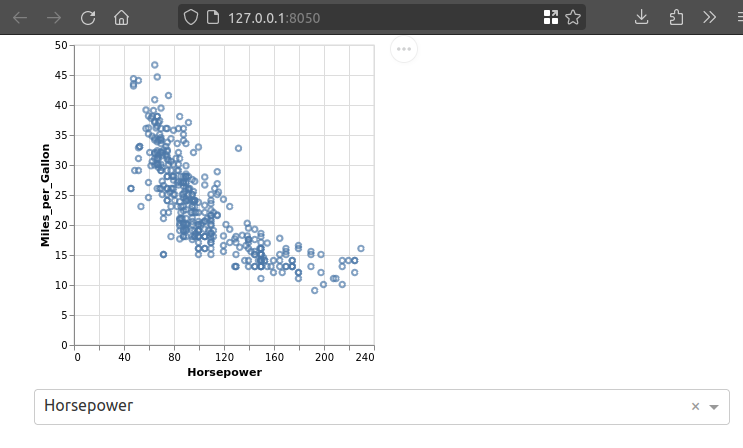

If you want the chart to stretch as wide as the dropdown,
you need to [follow the instructions ](https://github.com/altair-viz/dash-vega-components?tab=readme-ov-file#further-information)
to set the component width to 100% and the chart width to 'container'.
This is not that important for now,
we will talk more about styling later

```python
dvc.Vega(..., style={'width': '100%'})
alt.Chart(..., width='container')
```

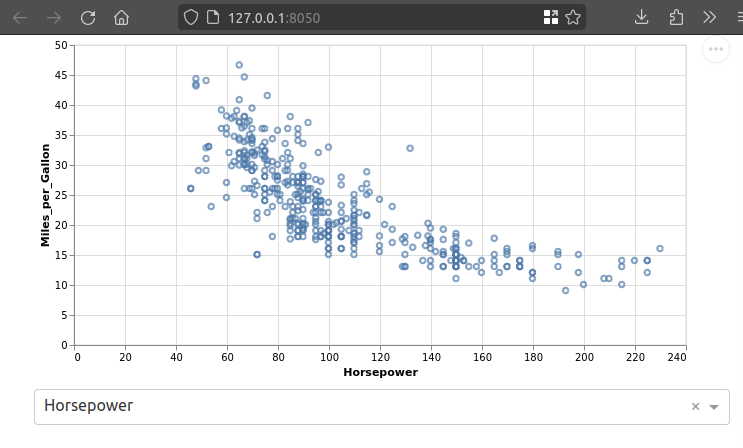

Another example could be how to use a slider to filter the data
based on the range of a column,
here the x-axis columns:

```python
from dash import Dash, dcc, callback, Output, Input
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
import altair as alt
from vega_datasets import data


cars = data.cars()

# Initiatlize the app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout
app.layout = dbc.Container([
    dvc.Vega(id='scatter', spec={}),
    dcc.RangeSlider(
        id='x-range',
        min=cars['Horsepower'].min(),
        max=cars['Horsepower'].max(),
        value=[cars['Horsepower'].min(), cars['Horsepower'].max()],
        # This will update the chart as the slider is dragged instead of only when it is released
        # Be careful with this for functions with heavy computations as it can slow down the app
        updatemode='drag'
    )
])

# Server side callbacks/reactivity
@callback(
    Output('scatter', 'spec'),
    Input('x-range', 'value')
)
def create_chart(x_range):
    return(
        alt.Chart(
            # I'm using query here but you could also do the following
            # cars[cars['Horsepower'].between(x_range[0], x_range[1])]
            cars.query('Horsepower.between(@x_range[0], @x_range[1])')
        ).mark_point().encode(
            x='Horsepower',
            y='Miles_per_Gallon',
            tooltip='Origin'
        ).interactive().to_dict()
    )

# Run the app/dashboard
if __name__ == '__main__':
    app.run(debug=True)
```

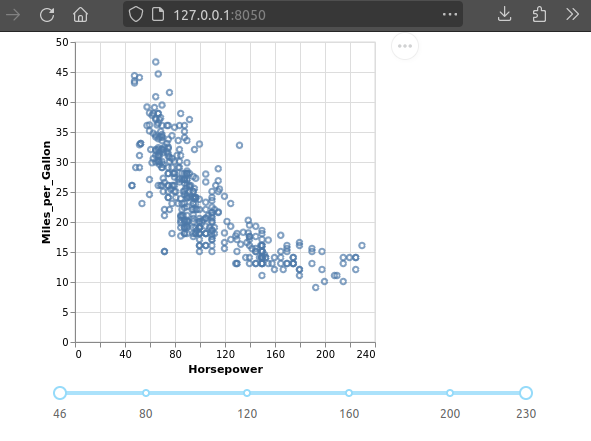

### Shiny

```r
options(shiny.port = 8050, shiny.autoreload = TRUE)

library(shiny)
library(ggplot2)


# Layout
ui <- fluidPage(
    plotOutput("plot", width = "400px")
)

# Server side callbacks/reactivity
server <- function(input, output, session) {
    output$plot <- renderPlot({
        ggplot(mtcars, aes(x = hp, y = mpg)) +
            geom_point()
    })
}

# Run the app/dashboard
shinyApp(ui, server)
```

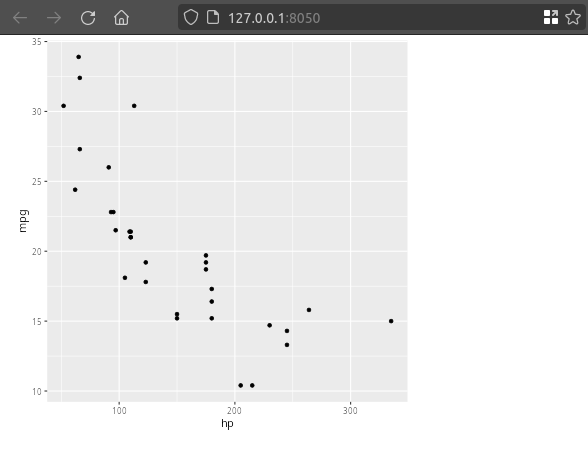

Using a dropdown for the column selection:

```r
options(shiny.port = 8050, shiny.autoreload = TRUE)

library(shiny)
library(ggplot2)


# Layout
ui <- fluidPage(
    plotOutput("plot", width = "400px"),
    selectInput(
        'x_col',
        'x-axis column',
        choices = colnames(mtcars),
        selected = 'hp'
    )
)

# Server side callbacks/reactivity
server <- function(input, output, session) {
    output$plot <- renderPlot({
        return(
            # These are equivalent ways of using the input$x_col with ggplot
            # Refer to lec 8 in 523 on Tidy Evaluation for more details
            # ggplot(mtcars, aes(x = !!as.symbol(input$x_col), y = mpg)) +
            ggplot(mtcars, aes(x = !!sym(input$x_col), y = mpg)) +
                geom_point()
        )
    })
}

# Run the app/dashboard
shinyApp(ui, server)
```

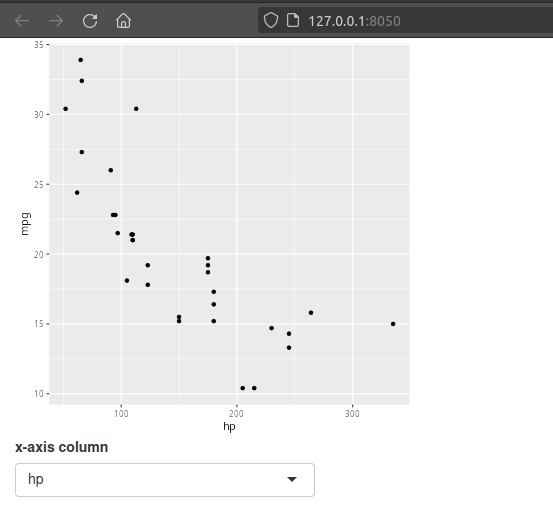

Sliders in shiny:

```r
options(shiny.port = 8050, shiny.autoreload = TRUE)

library(shiny)
library(ggplot2)
library(dplyr)


# Layout
ui <- fluidPage(
    plotOutput("plot", width = "400px"),
    sliderInput(
        'x_range',
        'x-axis range',
        min = mtcars$hp |> min(),
        max = mtcars$hp |> max(),
        value = c(mtcars$hp |> min(), mtcars$hp |> max())
    )
)

# Server side callbacks/reactivity
server <- function(input, output, session) {
    output$plot <- renderPlot({
        return(
            ggplot(
                mtcars |> filter(
                    between(hp, input$x_range[1], input$x_range[2])
                    ),
                aes(x = hp, y = mpg)
            ) +
                geom_point()
        )
    })
}

# Run the app/dashboard
shinyApp(ui, server)
```

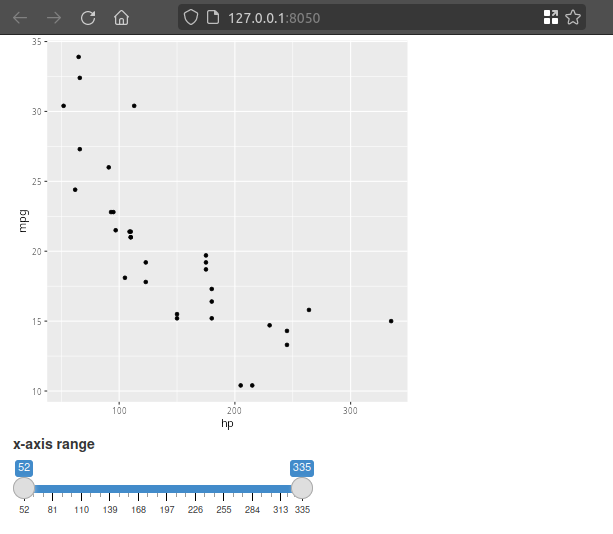

If we want to use `ggplotly` for tooltips and zooming,
we need to use the `plotly` package and the `ggplotly` function,
together with `renderPlotly` instead of `plotlyOutput`.

```r
options(shiny.port = 8050, shiny.autoreload = TRUE)

library(shiny)
library(ggplot2)
library(dplyr)
library(plotly)


# Layout
ui <- fluidPage(
    plotlyOutput("plot", width = "400px"),
    sliderInput(
        'x_range',
        'x-axis range',
        min = mtcars$hp |> min(),
        max = mtcars$hp |> max(),
        value = c(mtcars$hp |> min(), mtcars$hp |> max())
    )
)

# Server side callbacks/reactivity
server <- function(input, output, session) {
    output$plot <- renderPlotly({
        return(
            ggplotly(
                ggplot(
                    mtcars |> filter(
                        between(hp, input$x_range[1], input$x_range[2])
                        ),
                    aes(x = hp, y = mpg)
                ) +
                    geom_point()
            )
        )
    })
}

# Run the app/dashboard
shinyApp(ui, server)
```

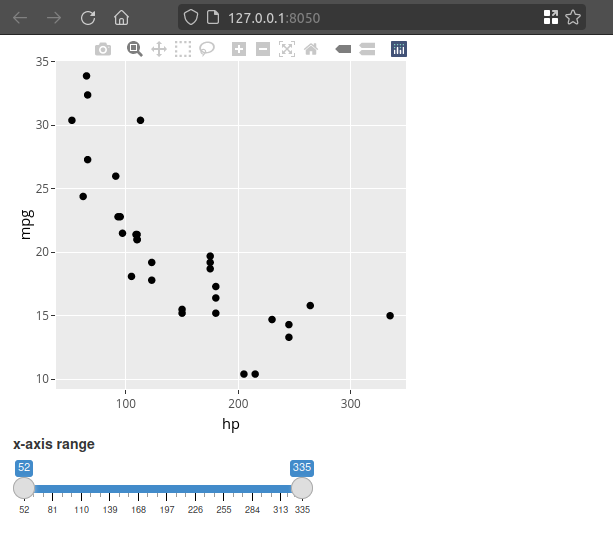

### Interacting with selected points

For both Altair and Plotly charts,
we can retrieve the values of the points selected in the chart
and use them in a callback.
There is a simple example below for a single selection
and an interval section can be found at the end of the notebook.
See here for more details about this in [altair](https://dash.plotly.com/dash-vega-components)
and [plotly](https://dash.plotly.com/interactive-graphing)

```python
from dash import Dash, dcc, callback, Output, Input, html
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
import altair as alt
from vega_datasets import data


cars = data.cars()

# Initiatlize the app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout
app.layout = dbc.Container([
    dvc.Vega(id='scatter', spec={}, signalsToObserve=['selection']),
    dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'),
    html.Br(),
    dcc.Markdown('You selected the following points:'),
    dcc.Markdown(id='signal_data_output')
])

# Server side callbacks/reactivity
@callback(
    Output('scatter', 'spec'),
    Output('signal_data_output', 'children'),
    Input('x-col', 'value'),
    Input('scatter', 'signalData'),
)
def create_chart(x_col, signal_data):
    # We need to pass `fields` to get usable output
    brush = alt.selection_point(fields=['Miles_per_Gallon', x_col], name='selection')
    chart = alt.Chart(cars).mark_point(size=50).encode(
            x=x_col,
            y='Miles_per_Gallon',
            tooltip='Origin'
        ).add_params(
            brush
        ).to_dict()
    # If the dictionary is empty we can't access a key in it
    if signal_data:
        return chart, f'{signal_data['selection']}'
    else:
        return chart, f'{signal_data}'

# Run the app/dashboard
if __name__ == '__main__':
    app.run(debug=True)

```

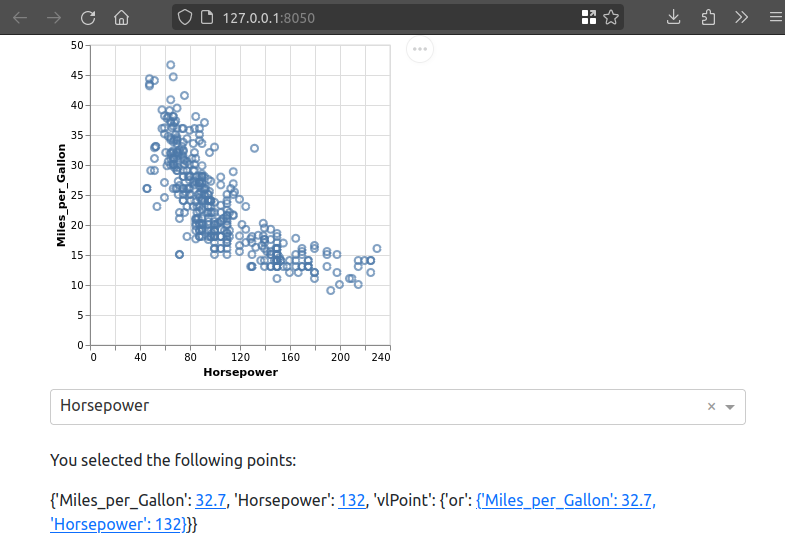

The returned format is a dictionary,
which you can change into a data frame via pandas
if desired.


<!-- Much better!
This is a great width, especially when we start adding columns to the app.
If you have many columns in your app and want it to stretch the full width of the screen,
you can set `fluid=True` in the container,
and we will always be using it instead of the top level div from now on.
We can also adjust the exact whitespace on the sides via the `max-width` css-class,
e.g. `style={'max-width': '85%'}`.
Just make sure to leave enough whitespace to frame your app
and not make it look stretched out
(unless creating an intentional effect by doing so). -->


## Layouts

### Bootstrap grid basics

For laying out our app's components,
we're going to use a framework called "Bootstrap".
Bootstrap is the world's most popular frontend framework,
providing ready-to-use templates for css and javascript,
that save developers time.

You have already seen how to use bootstrap themes
to change the general appearance of the app,
and here we're going to look close at Bootstrap's grid layouts.
A grid layout consists of a list of rows,
where each row can contain a list of columns,
and each column includes a list of components.
In other words,
the `dbc.Row` component is a wrapper for columns.
and yout of your app should be built as a series of rows of columns.
The `dbc.Col` component should always be used as an immediate child of Row
and is a wrapper for your content that ensures it takes up the correct amount of horizontal space.
Let's see how this looks like in code,
so it is easier to understand:

```python
app.layout = dbc.Container(
    [
        dbc.Row(dbc.Col(html.Div("A single column"))),
        dbc.Row(
            [
                dbc.Col(html.Div("One of three columns")),
                dbc.Col(html.Div("One of three columns")),
                dbc.Col(html.Div("One of three columns")),
            ]
        ),
    ]
)
```

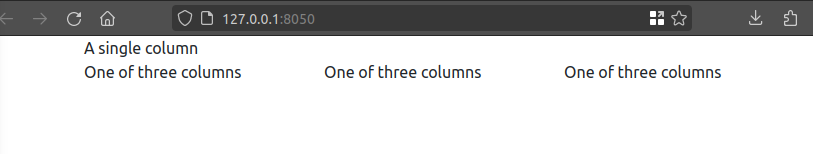

In the example above,
all we only use the `html.Div` component for clarity,
but we could use any input and output components the same way (charts, widgets, table, etc).
[There are some great illustrations in the docs](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/layout/)
that make it even more clear by styling the background of each column.
The corresponding one for our app
looks like this:

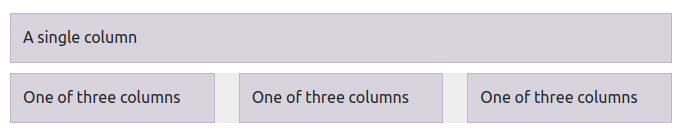

By default,
Boostrap defines a coordinate system that has 12 horizontal grid spaces
that will be divided over the available columns.
In the example above,
the single column stretches over all 12 grid spaces,
whereas the three column sharing a row occupy 4 grid spaces each (minus the gap between them).
Often,
we want to control how many spaces a column is taking,
e.g. to create a narrow side panel of global widgets.
We can do this by specifying the width of each column.
We can use the `width` parameter to set an exact size for a column.
However,
it is usually more convenient to use the `md` ("medium") parameter,
which sets a specific size for computers/tablets (screens wider than 768px),
but let's bootstrap figure out the widths on devices with smaller screens,
such as cell phones.


```python
app.layout = dbc.Container(
    [
        dbc.Row(
            dbc.Col(html.Div("A single, half-width column"), md=6)
        ),
        dbc.Row(
            dbc.Col(html.Div("An automatically sized column"), md="auto")
        ),
        dbc.Row(
            [
                dbc.Col(html.Div("One of three columns"), md=3),
                dbc.Col(html.Div("One of three columns")),
                dbc.Col(html.Div("One of three columns"), md=3),
            ]
        ),
    ]
)
```

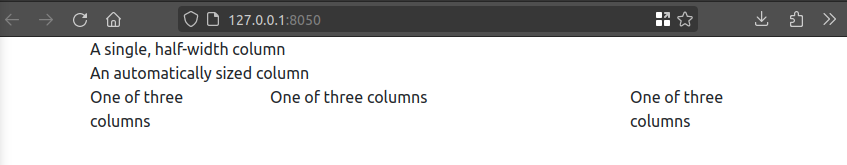

Again,
the Boorstrap component docs have a useful illustration that indicates exactly how much space each column occupies:


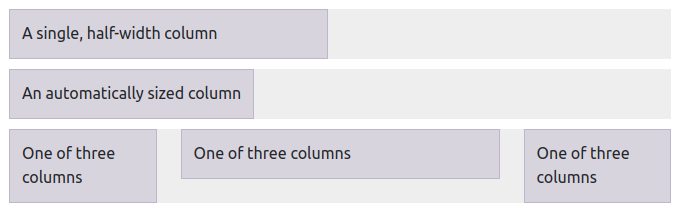

There is much more detail about individual configurations in
[the Boostrap components layouts docs](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/layout/)
including how to use adaptive screen sizing for mobile devices
and how to remove gaps between columns.

### Laying out our widgets and charts in a grid

Let's use what we just learned to 
put the two dropdown widget in it's own column to the left of the plot.

```python
# Layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower')),
        dbc.Col(dvc.Vega(id='scatter', spec={})),
    ])
])
```

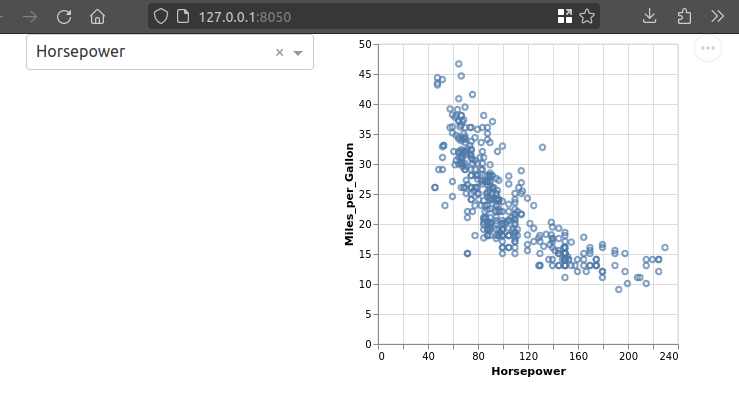


### Cards

We will keep learning about more complex grid layouts,
as we introduce a few additional components,
starting with [cards](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/card/).
Cards are useful to display important numerical summaries/metrics/key performance indicators.
Here we create a single card above our chart:

```python
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'), md=4),
        dbc.Col(
            [
                dbc.Card([dbc.CardHeader('A title'), dbc.CardBody('An important number')]),
                dvc.Vega(id='scatter', spec={}),
            ],
        md=8
        )
    ])
])
```

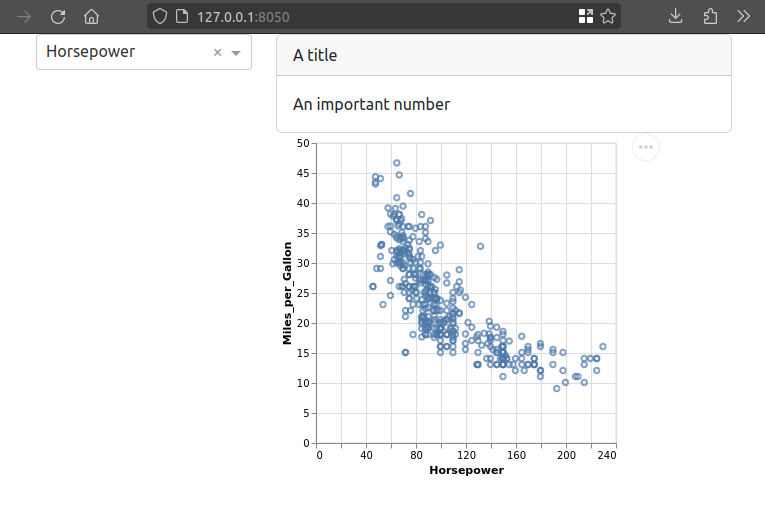

We can update the card from the function,
e.g. to show the average value of the selected column for all the charts.
For this we will make adjustments both to the callback
and the layout.
Our app now looks like this:

```python
from dash import Dash, dcc, callback, Output, Input
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
import altair as alt
from vega_datasets import data


cars = data.cars()

# Initiatlize the app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'), md=4),
        dbc.Col(
            [
                dbc.Card(id='card-avg'),
                dvc.Vega(id='scatter', spec={}),
            ],
        md=8
        )
    ])
])

# Server side callbacks/reactivity
@callback(
    Output('scatter', 'spec'),
    Output('card-avg', 'children'),
    Input('x-col', 'value')
)
def create_chart(x_col):
    chart = alt.Chart(cars).mark_point().encode(
            x=x_col,
            y='Miles_per_Gallon',
            tooltip='Origin'
        ).interactive().to_dict()

    card_avg = [
        dbc.CardHeader(f'Average {x_col}'),
        dbc.CardBody(f'{cars[x_col].mean() :.1f}')
    ]
    
    return chart, card_avg


# Run the app/dashboard
if __name__ == '__main__':
    app.run(debug=True)
```

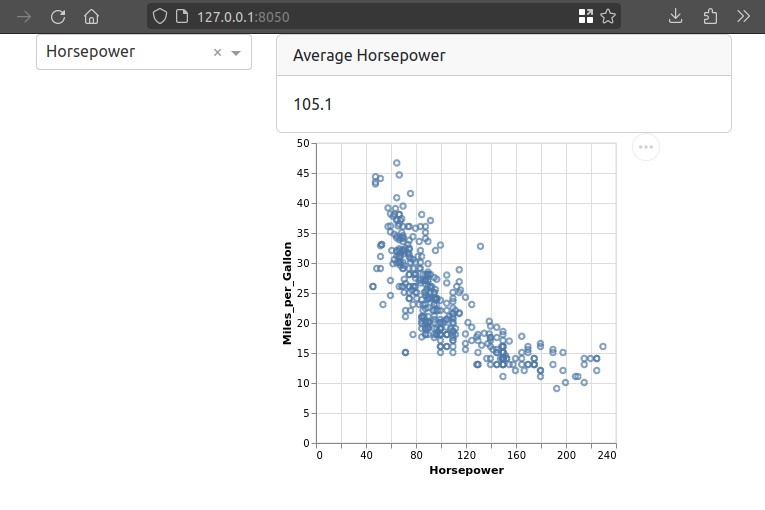

### Tabs

Tabs are useful for selectively displaying different content on demand.
For example,
you might have two sets of charts that you don't want to display  togeher,
or a separate page where you show the underlying data.
A more complex alternative to Tabs is to create an [app with multiple pages](https://dash.plotly.com/urls)
([more details](https://open-resources.github.io/dash_curriculum/part5/chapter14.html)).
The advantage of multiple pages is that not all the data is loaded at once,
but selectively as each page loads,
which can be helpful if your app is experience slowdown.
One main advantage of tabs is that switching between them is smoother,
since they are just hiding/unhiding components,
and they are a good default until you run into performance issues
and can consider switching to pages.
There is a tab component both in [dash core components](https://dash.plotly.com/dash-core-components/tabs)
and in the [dash bootstrap components](https://dash-bootstrap-components.opensource.faculty.ai/docs/components/tabs/);
their only difference in the aesthethics.

```python
# Layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'), md=4),
        dbc.Col(
            dbc.Tabs(
                [
                    dbc.Tab(
                        [
                            dbc.Card(id='card-avg'),
                            dvc.Vega(id='scatter', spec={}),
                        ],
                        label='Chart'
                    ),
                    dbc.Tab(
                        [
                            dcc.Markdown(cars.describe().to_markdown()),
                        ],
                        label='Data summary'
                    )
                ],
            ),
            md=8
        )
    ])
])
```

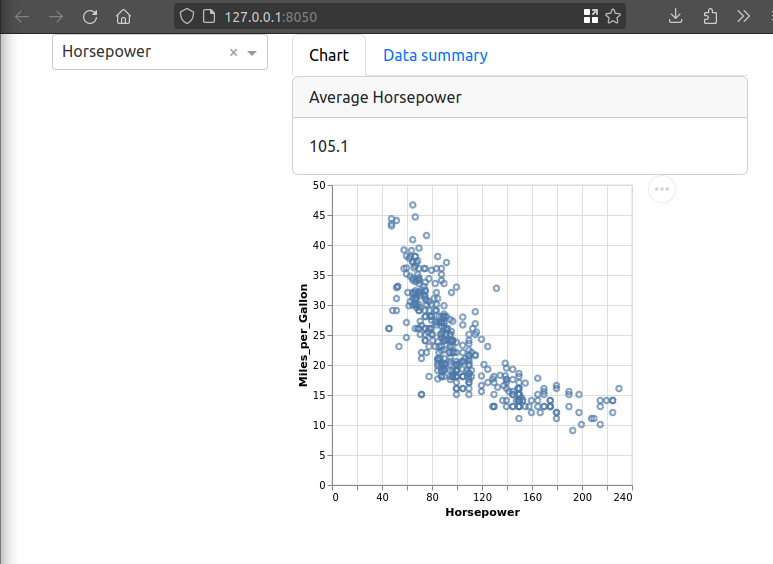

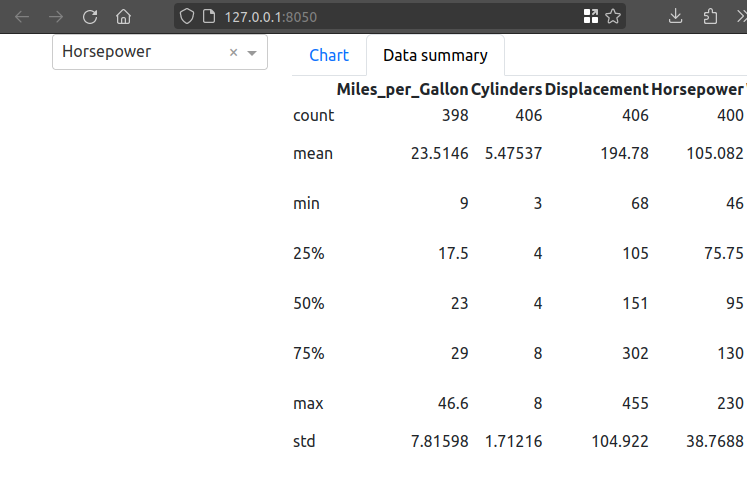

If we would have used `dcc.Tabs`/`dcc.Tab` instead, the style would have looked like this:

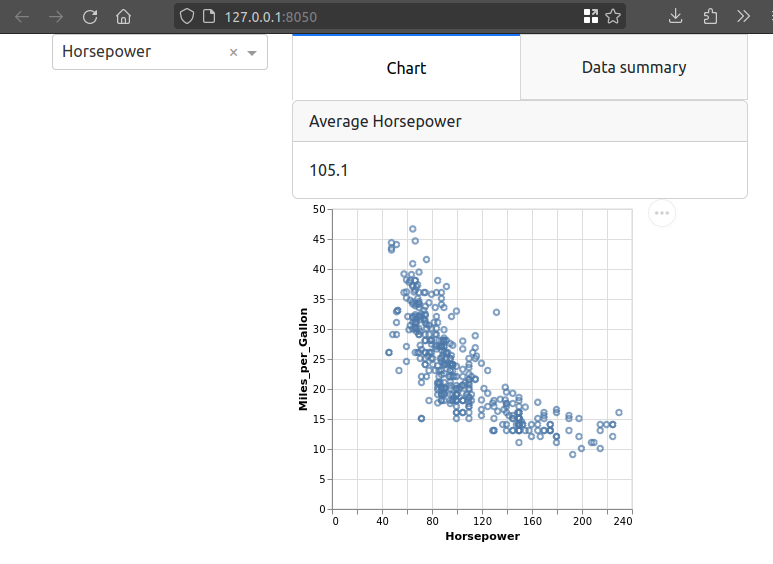


### A bit more complex app

Putting together what we have learned we can make a more complext app,
which updates both basedon dropdowns
and chart selections.

```python
from dash import Dash, dcc, callback, Output, Input, html
import dash_bootstrap_components as dbc
import dash_vega_components as dvc
import altair as alt
from vega_datasets import data


cars = data.cars()

# Initiatlize the app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1('carXplorer'),
            html.Br(),
        ]),
    ]),
    dbc.Row([
        dbc.Col(
            [
                dbc.Label('Select x-column'),
                dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'),
                html.Br(),
                dbc.Label('Filter on Origin'),
                dcc.Dropdown(id='origin-filter', options=cars['Origin'].unique(), value='USA'),
            ],
            md=4
        ),
        dbc.Col(
            [
                dbc.Row([
                    dbc.Col(
                        dbc.Card(id='card-avg')
                    ),
                    dbc.Col(
                        dbc.Card(id='card-count')
                    ),
                ]),
                dbc.Row(
                    dbc.Col(
                        dvc.Vega(
                            id='scatter',
                            spec={},
                            signalsToObserve=['scatter_select'],
                            style={'width': '100%'}
                        )
                    )
                )
            ],
            md=8
        )
    ]),
])


# Server side callbacks/reactivity
@callback(
    Output('scatter', 'spec'),
    Output('card-avg', 'children'),
    Output('card-count', 'children'),
    Input('x-col', 'value'),
    Input('origin-filter', 'value'),
    Input('scatter', 'signalData'),
)
def create_chart(x_col, origin, signal_data):
    chart_df = cars[cars['Origin'] == origin]
    selection = alt.selection_interval(name='scatter_select')
    chart = alt.Chart(chart_df, width='container').mark_point().encode(
            x=x_col,
            y='Miles_per_Gallon',
            tooltip='Origin',
            opacity=alt.condition(selection, alt.value(0.8), alt.value(0.2))
        ).add_params(
            selection
        ).to_dict()

    brush_selection = signal_data.get("scatter_select", {})
    if brush_selection:
        filter = " and ".join(
            [f"{v[0]} <= `{k}` <= {v[1]}" for k, v in brush_selection.items()]
        )
        chart_df_filtered = chart_df.query(filter)
    else:
        chart_df_filtered = chart_df
    card_count = [
        dbc.CardHeader('Points in selection'),
        dbc.CardBody(f'{chart_df_filtered.shape[0]}')
    ]
    card_avg = [
        dbc.CardHeader(f'Average {x_col}'),
        dbc.CardBody(f'{chart_df_filtered[x_col].mean() :.1f}')
    ]
    return chart, card_avg, card_count


# Run the app/dashboard
if __name__ == '__main__':
    app.run(debug=True)
```

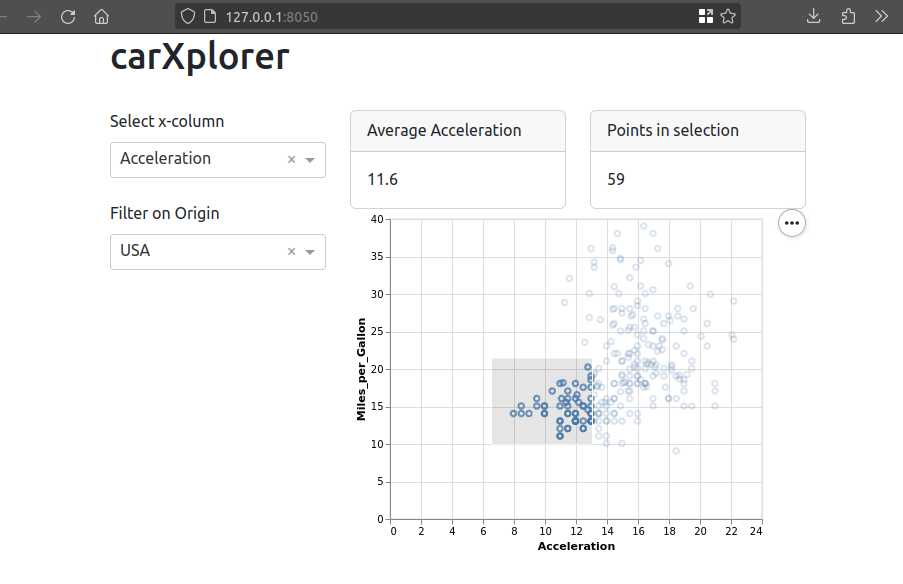

When we create the components and lay them out in the same place
section of the code (as we did above),
the layout section of the app quickly becomes complex with many nested components.
For code maintainability
and to improve the troubleshooting expereince,
it is recommended to separate these two steps,
and assign the components to variable names
before laying them out in the grid.
This is how you are expected to work
when creating your own apps.

```python
# Components
title = [html.H1('carXplorer'), html.Br()]
global_widgets = [
    dbc.Label('Select x-column'),
    dcc.Dropdown(id='x-col', options=cars.columns, value='Horsepower'),
    html.Br(),
    dbc.Label('Filter on Origin'),
    dcc.Dropdown(id='origin-filter', options=cars['Origin'].unique(), value='USA'),
]
card_avg = dbc.Card(id='card-avg')
card_count = dbc.Card(id='card-count')
scatter_chart = dvc.Vega(
    id='scatter',
    spec={},
    signalsToObserve=['scatter_select'],
    style={'width': '100%'}
)

# Layout
app.layout = dbc.Container([
    dbc.Row(dbc.Col(title)),
    dbc.Row([
        dbc.Col(global_widgets, md=4),
        dbc.Col(
            [
                dbc.Row([dbc.Col(card_avg), dbc.Col(card_count)]),
                dbc.Row(dbc.Col(scatter_chart))
            ],
            md=8
        )
    ])
])
```

## Deployment

### Dash

Deploying our app essentially means everything we need to do 
in order for it to become available for others to use.
For our dashboard,
this entails uploading our code to a computer that is always running
and has a web server so that other people can visit it.
On this web server,
we need to install all the required Python packages for our app,
and then run it via the same command we use on our computer.

Luckily,
we don't have to do these steps manually.
We're going to use the Render web service,
that will take care of most of these steps for us,
after we have set up a few configuration files.
Similar to how GitHub actions and tests can run as soon as you make your PR,
Render can build our app and start the Python server
as soon as we upload our code,
and even create previews of how our app will change based on a PR.

<!-- As an overview, this is what Render does:

1. New code is pushed to heroku's git repo.
2. Heroku installs the packages in `requirements.txt`.
3. Heroku runs whatever line you have in `Procfile`
   (in our case to serve your app on the web, but it could be other things). -->

Let's get going!

#### Prepare your app for deployment

You need to change two things in your app for deployment:

1. Turn of debug mode
    - Instead of `app.run(debug=True)` you will set it to `False` or just leave it out (`False` is the default)
2. Add a `server` variable
    - Under the line `app = Dash(...)`, add a line that reads `server = app.server`.
    - This is a convention in dash, and will be needed when deploying dash apps in general.

#### Create a pip requirements file

Render uses `pip` instead of `conda` to install dependencies,
so we will need to create a `requirements.txt` file in the root of your repo
to control what Render will install.
It is recommended that you create `requirements.txt` manually,
to avoid that you get a lot of conda-specific packages included that we don't need,
but you can use `python -m pip list --format freeze > requirements.txt`
as a starting point.
A minimal requirements file only need `dash` and `gunicorn`,
but it is more likely yours will look something like this

```
gunicorn==21.2.*
dash==2.16.*
dash-bootstrap-components==1.5.*
dash-vega-components==0.9.*
altair==5.3.*
pandas==2.2.*
```

The requirements file should contain version numbers as you can see above,
to make sure it will install easily in the future.
It can be a good idea to use a `*` for the last position in the version number,
since this means that you are accepting minor bugfix updates.

We also need to include the package `gunicorn`,
although that is not something we use locally.
`gunicorn` is a HTTP server specifically for Python web applications
which runs natively in Unix.
It takes care of the communication between the Python app
and the webserver,
and is required for Render (and many other web serices).

#### Deploy on render.com

1. The first step is to get an account at https://render.com.
For this lab,
you can either create a common account that all of you share,
or have one dedicated person doing the deployment
(but it is good to have at least one backup person!).
You will need to link it to one person's GitHub.com account.
Render provides us with Linux web servers configured to run apps in Python
and other languages,
so that we don't have to worry about building them ourselves.

2. Next, click the `New +` button in the top right corner
and select `Web Service`:

    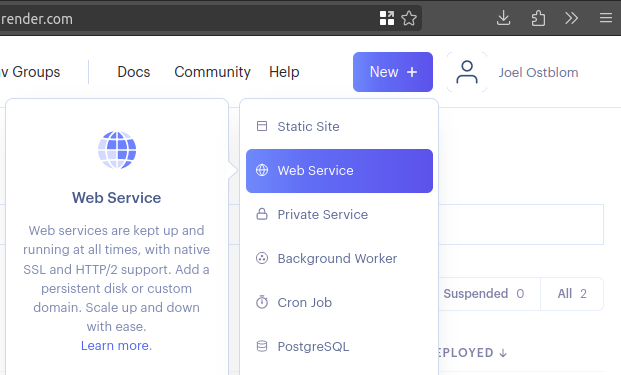

3. Select `Build and deploy from a Git repository`:

    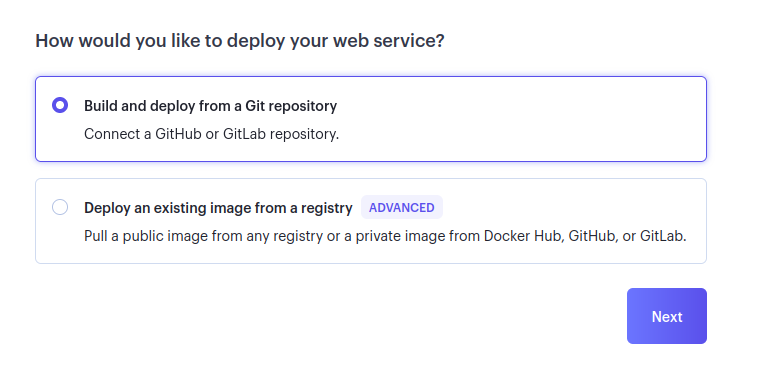

4. Find the name of your repository and click `Connect`.
    - It is possible that you might not be able to find your repo. If that's the case, **let me know** and paste the full URL in to `Public Git Repository` instead.
    - If you are able to find your repo but you run into an issue connecting to GitHub,
      which mentions that you need admin access, try with someone else's account in the group.
      It seems like not all your accounts are added to the UBC-MDS organization.

    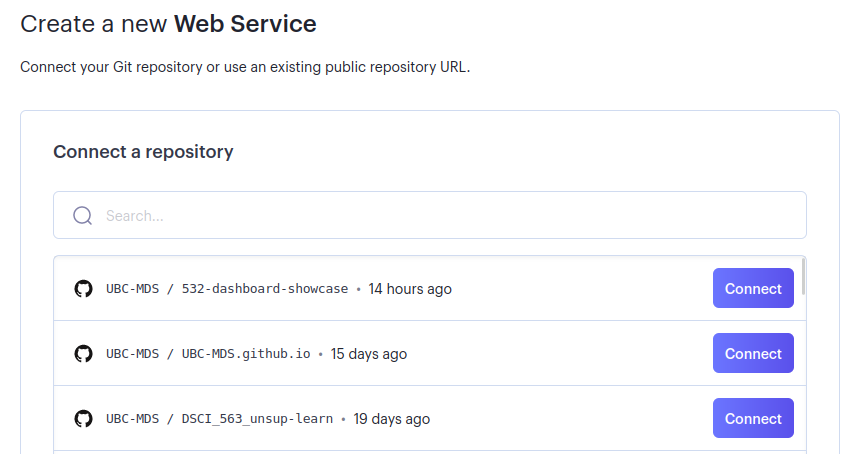

5. In the setup screen that follows, navigate down to `Startup Command` section and change it to `gunicorn src.app:server`. This tells `gunicorn` to look in the folder `src` for the file `app.py` and use the variable `server` in that file (the one we just created above) to launch the app.

    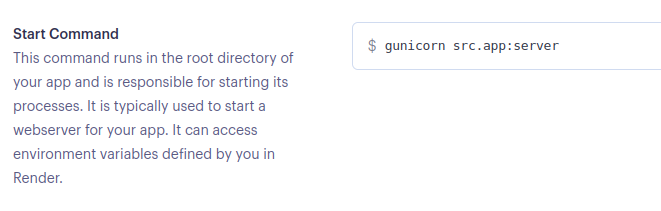 

6. Under `Instance Type`, select `Free` tier for "Hobby" projects.

    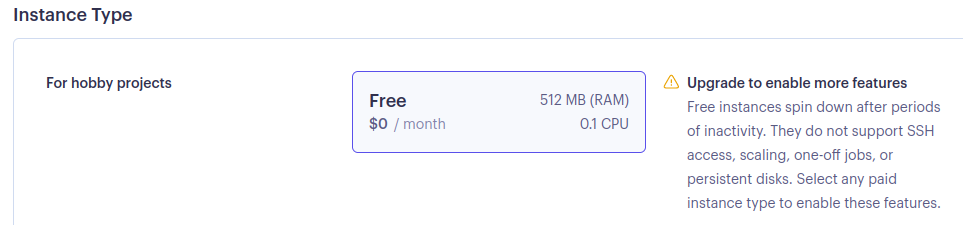

7. Click `Create` web service at the bottom; you will be taken to a screen with an empty log that looks like this:

    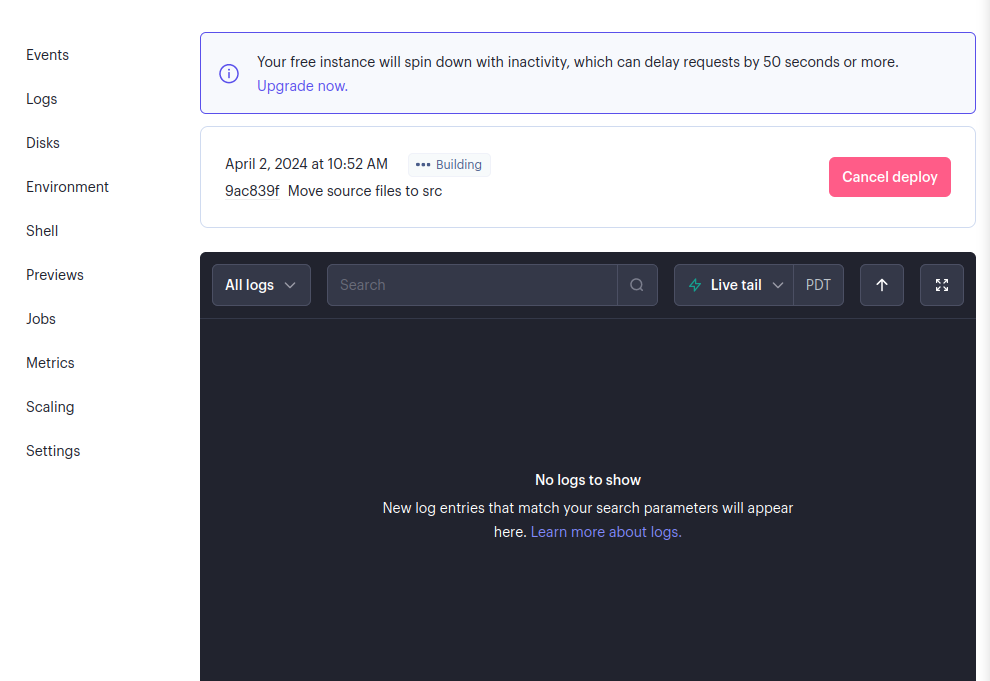

8. After a few seconds, the build and deployment process will kick in and you will start to see the log being populated. If it is run sucessfully, it should look like this:

    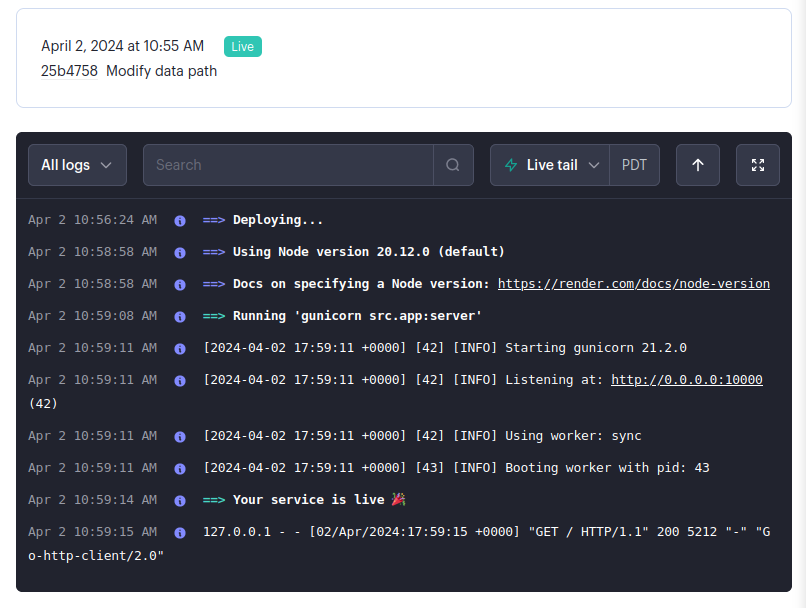

    If it fails, you need to read the error message in the console to figure out what has gone wrong. Here is an example of an error message:

    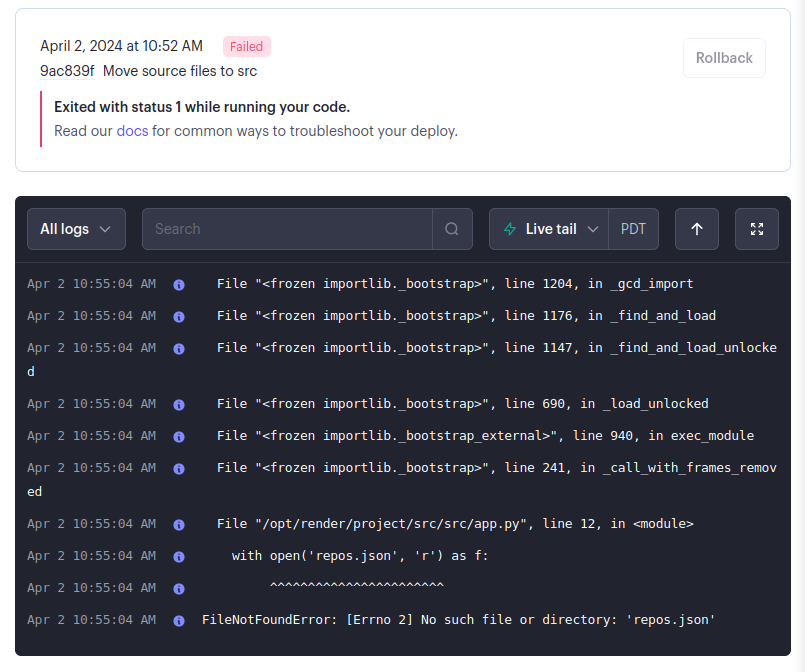

    This particular message says that it can't find the data file.
    To run into less troubles/difference between how the remotely deployed
    and local development version of your app finds data files,
    follow the folllowing:
    - Put data files inside a `data/` directory (with possible subfolders such as `raw` and `processed`.
    - All code should reference files relative the root directory. Even if you have code insdie the `src` folder, your should reference data with `data/my-file.csv` rather than using `../data/my-file.csv`.
    - When you develop locally,
      start dash from the root directory of your repo,
      not from the `src` folder, i.e. `python src/app.py`,
      which should be the default in vscode.

9. Click the link in the top right corner to view your deployed dashboard!
   This is public on the web, so you can share (show off) for anyone =)

    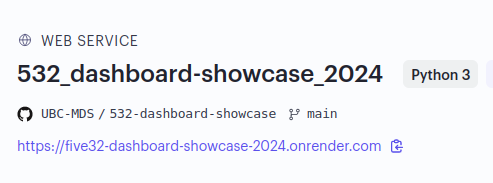

10. Click `Previews` and enable `Pull Request Previews`. Each time you create a PR towards the main branch, Render will create a link for you so that you can preview what these changes will look like when the PR is merged, which is convenient for the review process.

    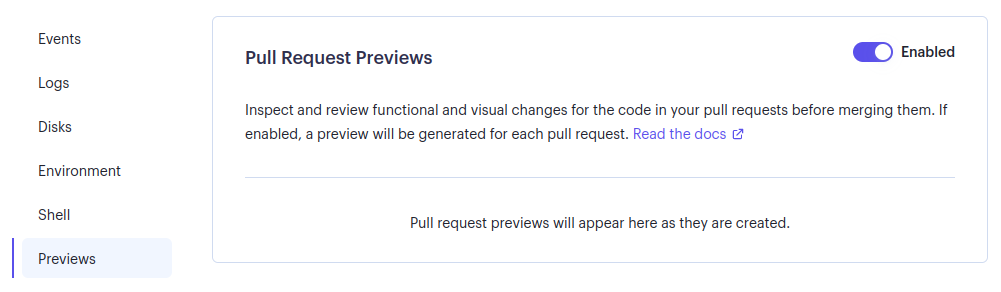

    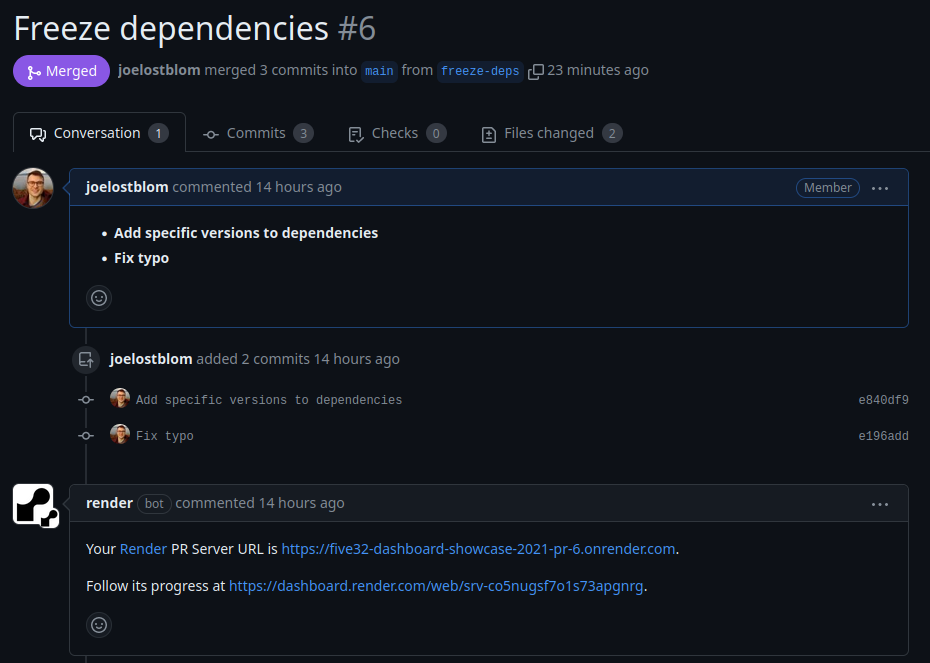

11. Click `Settings`, go down to `Auto-Deploy` and click `No`.

    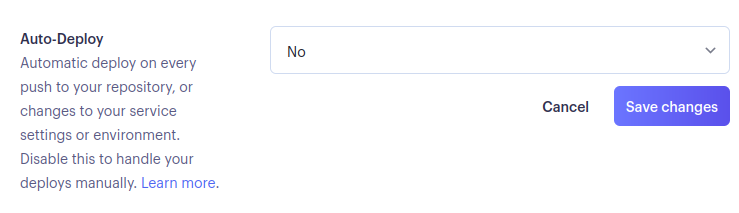
    
    Then scroll all the way up and click `Manual Deploy` and select/type the commit corresponding to your latest milestone. The reason we do it this way is that you want more control over the changes that go public, rather than having every update to the repo potentially break the app. Instead you only update manually every time you make a release on GitHub (and alternative would be to create a `production` branch in the repo and have two instances of `render`: one for the deploy previews against the `main` branch and one for the `production` branch, but that's a but more involved).
    
    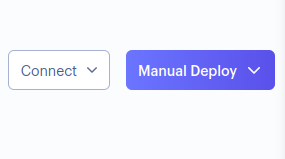

YOU DID IT!!!!! :raise_hands:

If your app fails to launch,
or you run into errors that you can't reproduce locally,
you can go and check out the build/deployment logs for what went wrong.
A common error is to forgot to include some package in the requirements file
(like I did twice while writing these notes...).

Your app might be slow on first launch,
after a while of activity because your server it stopped
to save costs unless you pay for an account.

### Shiny

Follow [this guide for how to deploy a shiny app](https://statsandr.com/blog/how-to-publish-shiny-app-example-with-shinyapps-io/) and [refer to the docs for more details](https://shiny.posit.co/r/articles/share/shinyapps/). If you want [to set up deploys previews with Shiny, you can follow the instructions in this video](https://www.youtube.com/watch?v=jk3VH7aDiYw).


### Useful links (optional)

As you get more advanced with your apps,
you might need access to something we don't cover in lecture
or just see a more detailed implementation
of something we only discussed briefly
The following links can be helpful for this:

- [Dash documentation](https://github.com/plotly/dash-docs)
- [Dash bootstrap components docs](https://dash-bootstrap-components.opensource.faculty.ai/docs/components)
- [Video walkthroughs of how to implement most things in Dash](https://www.youtube.com/@CharmingData/playlists)
- [Dash app gallery](https://dash-gallery.plotly.host/Portal/). Below are links to the source code of the apps that I think can be the most useful for you to check out:

Instructive:

- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-aix360-heart (Cards, layout)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-cuml-umap (sliders, single fig update)
- https://dash-bootstrap-components.opensource.faculty.ai/examples/simple-sidebar/ (sidebar with link to pages)
- https://dash-bootstrap-components.opensource.faculty.ai/examples/iris/ (grouped options in cards)
    
Advanced:

- https://github.com/plotly/dash-sample-apps/blob/master/apps/dash-nlp/app.py (layout, sidebar, tabs, NLP)
- https://github.com/plotly/dash-sample-apps/blob/master/apps/dash-clinical-analytics/app.py (Layout, advanced viz)
- https://github.com/plotly/dash-sample-apps/blob/master/apps/dash-daq-iv-tracer/app.py (DAQ widgets)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-financial-report (Multi-page app)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-interest-rate (Database, train ML model)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-live-model-training (streaming live data, [also see the docs](https://dash.plotly.com/live-updates))

For fun:

- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-gpt3-chatbot (gpt3 chatbot)
- https://github.com/plotly/dash-sample-apps/tree/master/apps/dash-gpt3-bars (Auto-create a bar chart from an description in English via GPT3)

---